In [1]:
import json
import math
import pickle
import sys
import threading
import time
import traceback
from collections import defaultdict
from concurrent.futures.thread import ThreadPoolExecutor
import numpy as np
from elote import EloCompetitor
from katrain.core.constants import (
    AI_LOCAL,
    AI_RANK,
    AI_TENUKI,
    AI_WEIGHTED,
    AI_PICK,
    AI_TERRITORY,
    AI_POLICY,
)

from settings import Logger
import matplotlib.pyplot as plt

[INFO   ] [Logger      ] Record log in C:\Users\sande\.kivy\logs\kivy_20-07-04_62.txt
[INFO   ] [deps        ] Successfully imported "kivy_deps.gstreamer" 0.1.17
[INFO   ] [deps        ] Successfully imported "kivy_deps.angle" 0.2.0
[INFO   ] [deps        ] Successfully imported "kivy_deps.glew" 0.2.0
[INFO   ] [deps        ] Successfully imported "kivy_deps.sdl2" 0.2.0
[INFO   ] [Kivy        ] v2.0.0rc2, git-78fb93b, 20200429
[INFO   ] [Kivy        ] Installed at "C:\Users\sande\Anaconda3\lib\site-packages\kivy\__init__.py"
[INFO   ] [Python      ] v3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
[INFO   ] [Python      ] Interpreter at "C:\Users\sande\Anaconda3\python.exe"


In [2]:
DB_FILENAME = "tournament_ai_performance.pickle"
class AI:
    def fix_settings(self):
        pass

try:
    with open(DB_FILENAME, "rb") as f:
        ai_database_loaded, all_results = pickle.load(f)
        ai_database = []
        for ai in ai_database_loaded:
            try:
                ai.fix_settings()  # update as required
                ai_database.append(ai)
            except Exception as e:
                print("Error loading AI", ai.strategy,e)
except FileNotFoundError:
    ai_database = []
    all_results = []

In [3]:
from sklearn.linear_model import LinearRegression
ranked = [ai for ai in ai_database if ai.strategy==AI_RANK]
calibrate = [ai for ai in ai_database if ai.strategy==AI_WEIGHTED]
policy = [ai for ai in ai_database if ai.strategy==AI_POLICY and ai.ai_settings['opening_moves']==0][0]

kyu_elo = [(r.ai_settings['kyu_rank'],r.elo_comp.rating) for r in ranked]
#kyu_elo.append( (-5,policy.elo_comp.rating) ) # policy ~5d
kyu_elo = sorted(kyu_elo)
kyu,elo = zip(*kyu_elo)


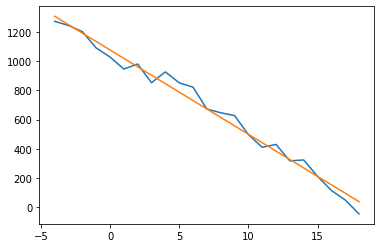

In [4]:
kyu2 = np.array(kyu)[:,np.newaxis]
reg = LinearRegression().fit(kyu2,elo)
plt.plot(kyu,elo,kyu,reg.predict(kyu2))

In [17]:
wt_elo =  [([r.ai_settings['weaken_fac']],r.elo_comp.rating) for r in calibrate]
x,y = zip(*wt_elo)
reg = LinearRegression().fit(x, y)
py = reg.predict(x)

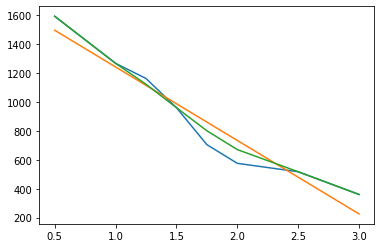

In [30]:
plt.plot(x,y,x,py,x,ys)

In [19]:
x

([0.5], [1.0], [1.25], [1.5], [1.75], [2], [2.5], [3.0])

In [29]:
ys = (1591.4486833932992,
 1266.2591850212696,
 1121.5661132041557,
 960.0966363156612,
 800.3124873968906,
 670.1137021076612,
 516.8371296455036,
 359.9621037249864)

In [35]:
list(zip([a[0] for a in x],ys))

[(0.5, 1591.4486833932992),
 (1.0, 1266.2591850212696),
 (1.25, 1121.5661132041557),
 (1.5, 960.0966363156612),
 (1.75, 800.3124873968906),
 (2, 670.1137021076612),
 (2.5, 516.8371296455036),
 (3.0, 359.9621037249864)]

In [37]:
[ (y,x) for x,y in [
    (-2, 1191.101167831912),
    (-1, 1133.5145700896292),
    (0, 1075.9279723473464),
    (1, 1018.3413746050636),
    (2, 960.7547768627808),
    (3, 903.168179120498),
    (4, 845.5815813782152),
    (5, 787.9949836359324),
    (6, 730.4083858936496),
    (7, 672.8217881513667),
    (8, 615.235190409084),
    (9, 557.6485926668012),
    (10, 500.06199492451833),
    (11, 442.4753971822355),
    (12, 384.88879943995266),
    (13, 327.30220169766983),
    (14, 269.7156039553871),
    (15, 212.12900621310428),
    (16, 154.54240847082144),
    (17, 96.95581072853861),
    (18, 39.36921298625589),
]][::-1]

[(39.36921298625589, 18),
 (96.95581072853861, 17),
 (154.54240847082144, 16),
 (212.12900621310428, 15),
 (269.7156039553871, 14),
 (327.30220169766983, 13),
 (384.88879943995266, 12),
 (442.4753971822355, 11),
 (500.06199492451833, 10),
 (557.6485926668012, 9),
 (615.235190409084, 8),
 (672.8217881513667, 7),
 (730.4083858936496, 6),
 (787.9949836359324, 5),
 (845.5815813782152, 4),
 (903.168179120498, 3),
 (960.7547768627808, 2),
 (1018.3413746050636, 1),
 (1075.9279723473464, 0),
 (1133.5145700896292, -1),
 (1191.101167831912, -2)]